## Роман Аблизен

In [449]:
import pandas as pd
import numpy as np
import seaborn as sns

In [166]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [450]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## Загружаем и отделяем необходимые нам данные

In [285]:
data = pd.read_csv("owid-covid-data.csv")

In [286]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [287]:
data = data[data.location == 'Russia'][["date","total_cases","new_cases"]]

In [288]:
data["datetime"] = pd.to_datetime(data.date)

In [289]:
data.head()

,date,total_cases,new_cases,datetime
123754,2020-01-31,2.0,2.0,2020-01-31
123755,2020-02-01,2.0,0.0,2020-02-01
123756,2020-02-02,2.0,0.0,2020-02-02
123757,2020-02-03,2.0,0.0,2020-02-03
123758,2020-02-04,2.0,0.0,2020-02-04


In [290]:
data = data[data.datetime >= pd.to_datetime("2020-03-03")] # Отделяем все что раньше 3 марта

In [76]:
data.new_cases[data.new_cases == 0] = 1 # по рекомендации

In [291]:
data = data[["total_cases","new_cases","datetime"]]

In [292]:
data["num"] = [i for i in range(1, len(data) + 1)]

In [293]:
data.head()

,total_cases,new_cases,datetime,num
123786,3.0,0.0,2020-03-03,1
123787,3.0,0.0,2020-03-04,2
123788,4.0,1.0,2020-03-05,3
123789,13.0,9.0,2020-03-06,4
123790,13.0,0.0,2020-03-07,5


In [101]:
data50 = data.iloc[:50,:]

## Графики целевых переменных

Text(0, 0.5, 'total_cases')

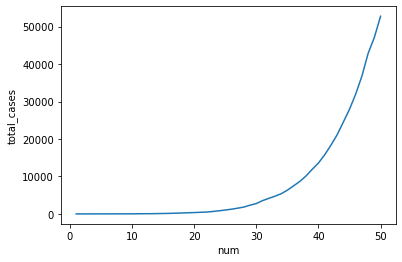

In [103]:
plt.plot(data50.num, data50.total_cases)
plt.xlabel("num")
plt.ylabel("total_cases")

Text(0, 0.5, 'new_cases')

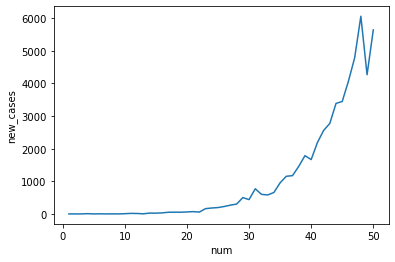

In [105]:
plt.plot(data50.num, data50.new_cases)
plt.xlabel("num")
plt.ylabel("new_cases")

## Линейная регрессия

y = exp(a * x + b)

значит

ln(y) = a * x + b

In [135]:
y_test = np.array(np.log(data50.total_cases))
y_test = y_test.reshape(-1,1)
x_test = np.array(data50.num)
x_test = x_test.reshape(-1,1)

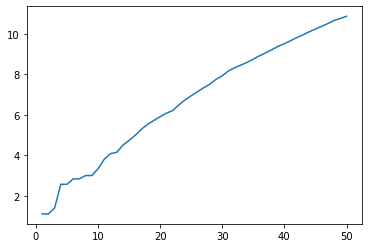

In [143]:
plt.plot(x_test, y_test)
plt.show()

### Веса линейной регрессии

In [256]:
lr = LinearRegression()
lr.fit(x_test, y_test)
a = lr.coef_
b = lr.intercept_
print("a = ", a[0][0])
print("b = ", b[0])

a =  0.19829091233588558
b =  1.6224462364488117


### Дисперсия шума : 

In [164]:
sigma_noise = np.sqrt ( np.sum( (y_test - lr.predict(x_test)) ** 2 ) / len(x_test) )
print(sigma_noise)

0.3490422059635659


### В качестве априорного распределения параметров возьмем 2мерное нормальное распределение с центром в (0, 0) и единичной матрицей ковариаций

In [282]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])



### Апостериорное распределение

In [318]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    xones = np.ones((len(x), 1))
    x_matrix = np.concatenate((xones, x), axis = 1)

    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)).reshape(-1,1) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array(y) ) )
    return mu_n, sigma_n

In [319]:
mu_n, sigma_n = bayesian_update(cur_mu, cur_sigma, x_test, y_test, sigma_noise)

In [374]:
print(" байесовский вывод:")
print(mu_n)
print()
print("веса, полученные с помощью линейной регрессии:")
print( b[0])
print( a[0][0])

 байесовский вывод:
[[1.61436785]
 [0.19853058]]

веса, полученные с помощью линейной регрессии:
1.6224462364488117
0.19829091233588558


### Отметим, что mu_n близко к весам линейной регрессии


### Предсказательное распределение

### Истинное значение:

In [434]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    ws = []
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
        #ws.append([w[0], w[1]])
    return res

In [507]:
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 1e5))
    #ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - .25), np.exp(mu[1]*xs + mu[0] + .25), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200, label="данные")
    ax.legend(fontsize=legend_fontsize)

In [508]:
x = sample_statistics(mu_n.reshape(2,), sigma_n, x_test.reshape(len(x_test),), n=20)

In [509]:
x = np.exp(x)

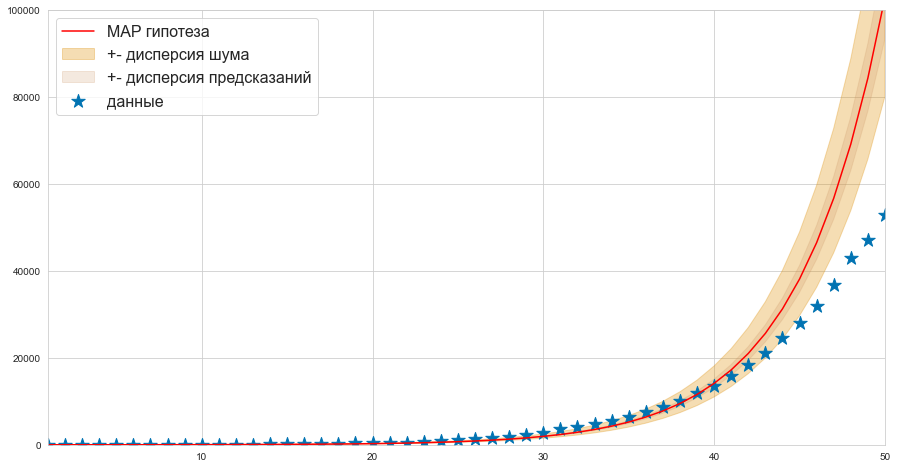

In [510]:
plot_predictions(x_test.reshape(len(x_test),), mu_n, x, [x_test, np.exp(y_test)])

### 1 мая

In [496]:
data[data.datetime == "2020-05-01"]

,total_cases,new_cases,datetime,num
123845,114431.0,7933.0,2020-05-01,60


In [498]:
n = 60
preds_1may = sample_statistics(mu_n.reshape(2,), sigma_n, np.array([n]), n=5000)
print("prediction: ", int(np.exp(np.mean(preds_1may))))
print("true value:", int(data[data.datetime == "2020-05-01"].total_cases))


prediction:  749050
true value: 114431


### 1 июня

In [499]:
data[data.datetime == "2020-06-01"]

,total_cases,new_cases,datetime,num
123876,414328.0,8485.0,2020-06-01,91


In [500]:
n = 91
preds_1may = sample_statistics(mu_n.reshape(2,), sigma_n, np.array([n]), n=5000)
print("prediction: ", int(np.exp(np.mean(preds_1may))))
print("true value:", int(data[data.datetime == "2020-06-01"].total_cases))

prediction:  351251361
true value: 414328


### 1 сентября

In [501]:
data[data.datetime == "2020-09-01"]

,total_cases,new_cases,datetime,num
123968,997072.0,4670.0,2020-09-01,183


In [502]:
n = 183
preds_1may = sample_statistics(mu_n.reshape(2,), sigma_n, np.array([n]), n=5000)
print("prediction: ", int(np.exp(np.mean(preds_1may))))
print("true value:", int(data[data.datetime == "2020-09-01"].total_cases))

prediction:  30184221896483348
true value: 997072
